> # Image Classification with CNNs
---
<br>

### Contents.
```
1. Introduction
2. Implementation (1) ResNet
3. Implementation (2) Clustering for classification
```
<br>

### Reference.
- [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)
- [TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

<br>


# 1. Introduction

---

<br>

### Goals.
```
1) Image Classification 이해
```


# 1.1. Image Classification 이해

- PPT 참고

<br>
<br>

# 2. Implementation (1) ResNet
---

<br>

### Goals.
```
1) ResNet
2) Residual Block
3) Pretrained Model 활용
```

## 2.1. ResNet
```
2015년 ILSVRC에서 우승한 CNN 모델로  Microsoft에서 제안함.
기존 모델들에서 신경망이 깊어질 수록 오히려 성능이 떨어짐을 관측했고,
이를 해결하기위해 skip/shortcut을 더해줌.
```
- paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

<br>



<br>

## 2.2. Residual Block

```
입력값을 출력값에 더해주도록 shortcut을 추가했다는 점이 기존 모델과의 차이점.
```


### 2.2.1. Residual Building Block

![](https://raw.githubusercontent.com/jarvislabsai/blog/master/build_resnet34_pytorch/images/res_block1.png)


<br>

## 2.3. Pretrained Model 활용
- pretrained model 불러오기
- 모델에 학습시켜 분류할 데이터를 준비
- fine tuning

### 2.3.1. Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### 2.3.2. Prepare Data

In [ ]:
# 모델 학습에 사용하기 위해 데이터변형 준비.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 데이터가 저장된 경로
data_dir = '/content/drive/Shareddrives/LG_AI_Workshop_21W/Image classification/hymenoptera_data'
assert os.path.exists(data_dir), "데이터 경로가 잘못됐습니다."

# 데이터셋
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val']}
print("\n",image_datasets['train'])
print("\n",image_datasets['val'])
print("\n한 데이터의 형태:",image_datasets['train'][0][0].shape)

# 데이터로더
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'val']}
print("\n학습 데이터로더의 길이:",len(dataloaders['train']))
print("테스트 데이터로더의 길이:",len(dataloaders['val']))

# 데이터 개수
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 학습데이터 클래스
class_names = image_datasets['train'].classes
print("\n학습할 데이터 클래스 리스트:",class_names)

# GPU 연결
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("연결된 GPU 자원:",device)


 Dataset ImageFolder
    Number of datapoints: 244
    Root location: /content/drive/Shareddrives/LG_AI_Workshop_21W/Image classification/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

 Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/drive/Shareddrives/LG_AI_Workshop_21W/Image classification/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

한 데이터의 형태: torch.Size([3, 224, 224])

학습 데이터로더의 길이: 61
테스트 데이터로더의 길

가져온 한 배치에 있는 데이터 형태: torch.Size([4, 3, 224, 224]) 



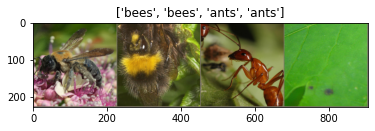

In [ ]:
# 불러온 데이터 확인
def imshow(input, title=None):
    """Imshow for Tensor."""
    input = input.numpy().transpose((1, 2, 0)) # 데이터의 채널 순서 변경
    mean = np.array([0.485, 0.456, 0.406]) # 각 채널의 픽셀값들의 평균
    std = np.array([0.229, 0.224, 0.225]) # 각 채널의 픽셀값들의 표준편차
    input = std * input + mean # 이미지의 각 채널의 픽셀값들의 분포가 위의 평균과 표준편차를 갖는 분포를 따르도록 바꿔줌
    input = np.clip(input, 0, 1) # 이미지의 픽셀값 중, 1보다 큰값을 모두 1로 바꿔줌
    plt.imshow(input) # 지금까지 변형시킨 이미지를 출력함.
    if title is not None: 
        plt.title(title) # 이미지 상단에 텍스트 출력.
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 대기.


# 학습 데이터의 한 배치를 얻음.
inputs, classes = next(iter(dataloaders['train']))
print("가져온 한 배치에 있는 데이터 형태:",inputs.shape,"\n")

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

### 2.3.3. Model
- ResNet-18
- 사전학습된 모델 사용하기
  - `pretrained =`
    - `True` : 사전에 학습된 모델 사용.
    - `False` : 사전에 학습된 모델 사용 안함.
- [이외의 사용 가능한 다른 모델들](https://pytorch.org/vision/stable/models.html)

In [ ]:
# models.사용할 모델(pretrained=사용여부선택)

resnet18_pretrained = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### 2.3.4. Prepare model for training
```
모델의 마지막 fc layer에서는 최종적으로 classification
```

In [ ]:
# 학습에 사용하기 위해 구조 변경
in_ftrs = resnet18_pretrained.fc.in_features
out_ftrs = resnet18_pretrained.fc.out_features
print("(변경 전) model의 fc layer에 입력되는 feature vector의 크기:",in_ftrs)
print("(변경 전) model의 fc layer에서 출력되는 feature vector의 크기:",out_ftrs)
resnet18_pretrained.fc = nn.Linear(in_ftrs, len(class_names))
print("(변경 후) model의 fc layer에서 출력되는 feature vector의 크기:",resnet18_pretrained.fc.out_features)
resnet18_pretrained = resnet18_pretrained.to(device)


(변경 전) model의 fc layer에 입력되는 feature vector의 크기: 512
(변경 전) model의 fc layer에서 출력되는 feature vector의 크기: 1000
(변경 후) model의 fc layer에서 출력되는 feature vector의 크기: 2


In [ ]:
# Loss 함수
criterion = nn.CrossEntropyLoss()

# Optimizer: 최적화 함수
# lr: 미분값을 얼마나 이동시킬 것인가
# momentum: 미분값에 관성을 주어 local minimum 문제를 해결하기 위함
optimizer_ft = optim.SGD(resnet18_pretrained.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    
                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

- 학습 진행

In [ ]:
model_ft = train_model(resnet18_pretrained, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

Epoch 0/0
----------
train Loss: 0.6442 Acc: 0.6844
val Loss: 0.2747 Acc: 0.8562

Training complete in 1m 11s
Best val Acc: 0.856209


- 출력결과 확인

In [ ]:
def normalize_data(input):
    input = input.numpy().transpose((1, 2, 0)) # 데이터의 채널 순서 변경
    mean = np.array([0.485, 0.456, 0.406]) # 각 채널의 픽셀값들의 평균
    std = np.array([0.229, 0.224, 0.225]) # 각 채널의 픽셀값들의 표준편차
    input = std * input + mean # 이미지의 각 채널의 픽셀값들의 분포가 위의 평균과 표준편차를 갖는 분포를 따르도록 바꿔줌
    input = np.clip(input, 0, 1) # 이미지의 픽셀값 중, 1보다 큰값을 모두 1로 바꿔줌
    
    return input


def visualize_model(model, num_images=6):
  was_training = model.training # 이전까지의 모델 모드 기록
  model.eval() # 모델을 평가모드로 전환.
  images_so_far = 0
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      
      for j in range(inputs.size()[0]):
        images_so_far += 1
        out_img = normalize_data(inputs.cpu().data[j])
        plt.figure(figsize=(4,4))
        plt.imshow(out_img)
        plt.title(f'predicted: {class_names[preds[j]]}\nground truth: {class_names[labels[j]]}')
        plt.axis('off')
        print()

        if images_so_far==num_images:
          break
      if images_so_far==num_images:
        break
    plt.show()

In [ ]:
visualize_model(model_ft)